In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Define constants
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 29  # Number of classes in the ASL dataset

# Load Pretrained MobileNetV2 without the top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split the dataset into training and validation sets
)

# Create training and validation generators
train_generator = train_datagen.flow_from_directory(
    'asl_alphabet_train',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    'asl_alphabet_train',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Get the total number of samples using the `n` attribute
total_train_samples = train_generator.n
total_val_samples = validation_generator.n

# Calculate steps per epoch
steps_per_epoch = total_train_samples // BATCH_SIZE
validation_steps = total_val_samples // BATCH_SIZE

# Convert generators to tf.data.Dataset
def generator_wrapper(generator):
    for data, labels in generator:
        yield data, labels

train_dataset = tf.data.Dataset.from_generator(
    lambda: generator_wrapper(train_generator),
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_WIDTH, IMG_HEIGHT, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, NUM_CLASSES), dtype=tf.float32)
    )
).unbatch().batch(BATCH_SIZE, drop_remainder=True).repeat()

validation_dataset = tf.data.Dataset.from_generator(
    lambda: generator_wrapper(validation_generator),
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_WIDTH, IMG_HEIGHT, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, NUM_CLASSES), dtype=tf.float32)
    )
).unbatch().batch(BATCH_SIZE, drop_remainder=True).repeat()

# Train the model with the custom top layers
history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    verbose=1,
)


Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.
Epoch 1/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 1805s 827ms/step - accuracy: 0.7741 - loss: 0.7753 - val_accuracy: 0.8272 - val_loss: 0.5699
Epoch 2/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 1108s 510ms/step - accuracy: 0.9396 - loss: 0.1840 - val_accuracy: 0.8268 - val_loss: 0.6114
Epoch 3/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 1112s 511ms/step - accuracy: 0.9502 - loss: 0.1516 - val_accuracy: 0.8270 - val_loss: 0.6595
Epoch 4/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 1117s 514ms/step - accuracy: 0.9566 - loss: 0.1326 - val_accuracy: 0.8458 - val_loss: 0.5864
Epoch 5/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 1112s 511ms/step - accuracy: 0.9616 - loss: 0.1198 - val_accuracy: 0.8416 - val_loss: 0.6472
Epoch 6/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 1114s 512ms/step - accuracy: 0.9627 - loss: 0.1159 - val_accuracy: 0.8413 - val_loss: 0.7172
Epoch 7/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 1107s 509ms/step - accuracy: 0.9644 - loss: 0.1107 - val_acc

In [21]:
model.save('asl_model_v2_1.h5')

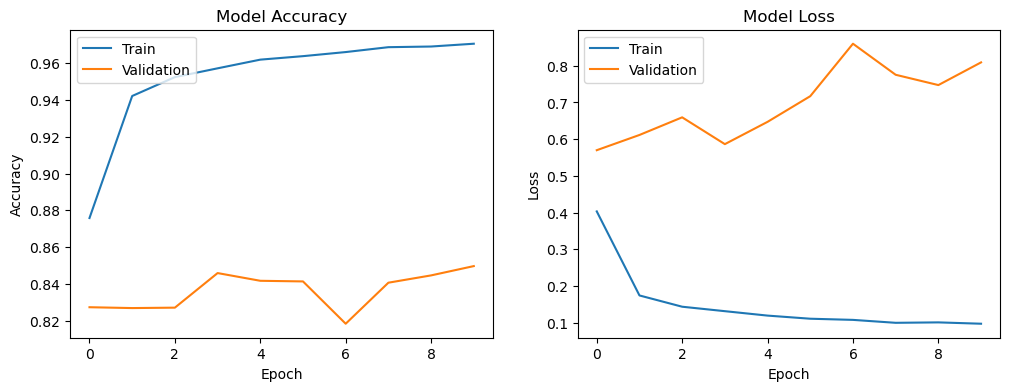

In [23]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [24]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Define the directory containing all test images
test_dir = 'asl_alphabet_test'  # Update this path

# Get a list of all image filenames
image_filenames = [f for f in os.listdir(test_dir) if os.path.isfile(os.path.join(test_dir, f))]

# Define an empty list to hold the processed images
test_images = []

# Loop over all filenames, load and preprocess each image
for img_name in image_filenames:
    img_path = os.path.join(test_dir, img_name)
    img = image.load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    test_images.append(img_array)

# Convert list to numpy array
test_images = np.vstack(test_images)

# Predict classes
predictions = model.predict(test_images)

# Get the predicted class indices
predicted_classes = np.argmax(predictions, axis=1)

# Map class indices to class labels
class_indices = {v: k for k, v in train_generator.class_indices.items()}  # Reverse the class_indices dictionary
predicted_labels = [class_indices[i] for i in predicted_classes]

# Print the results
for i, img_name in enumerate(image_filenames):
    print(f"{img_name} -> Predicted class: {predicted_labels[i]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
A_test.jpg -> Predicted class: A
B_test.jpg -> Predicted class: B
C_test.jpg -> Predicted class: C
D_test.jpg -> Predicted class: D
E_test.jpg -> Predicted class: E
F_test.jpg -> Predicted class: F
G_test.jpg -> Predicted class: G
H_test.jpg -> Predicted class: H
I_test.jpg -> Predicted class: I
J_test.jpg -> Predicted class: J
K_test.jpg -> Predicted class: K
L_test.jpg -> Predicted class: L
M_test.jpg -> Predicted class: M
nothing_test.jpg -> Predicted class: nothing
N_test.jpg -> Predicted class: N
O_test.jpg -> Predicted class: O
P_test.jpg -> Predicted class: P
Q_test.jpg -> Predicted class: Q
R_test.jpg -> Predicted class: R
space_test.jpg -> Predicted class: space
S_test.jpg -> Predicted class: S
T_test.jpg -> Predicted class: T
U_test.jpg -> Predicted class: U
V_test.jpg -> Predicted class: V
W_test.jpg -> Predicted class: W
X_test.jpg -> Predicted class: X
Y_test.jpg -> Predicted class: Y
Z_test.jpg -> Predicted class: Z
